# Task 5: Time Series Clustering

ECG time series clustering using Lead II signals.

1. Build univariate ECG time series per patient
2. Apply offset removal and amplitude scaling (z-normalization)
3. Construct PAA feature vectors
4. Compare KMeans, hierarchical clustering, and DBSCAN

Clustering uses only time series features, not tabular patient data.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy import stats
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

base_path = Path.cwd()
if base_path.name == "code":
    base_path = base_path.parent

data_path = base_path / "Data"
code_path = base_path / "code"

print(f"Working directory: {base_path}")
print(f"Data path: {data_path}")

# Import preprocessed time series data (preprocessed in notebook 3.1)
# This replaces the raw data loading to avoid redundant preprocessing
preprocessed_file = data_path / 'preprocessed_time_series.pkl'
print(f"\nLoading preprocessed time series data from: {preprocessed_file}")

with open(preprocessed_file, 'rb') as f:
    preprocessed_data = pickle.load(f)

# Extract data
subject_ids = preprocessed_data['subject_ids']
X_ts = preprocessed_data['preprocessed_equal_length']  # Shape: (n_subjects, 100)

print(f"\nLoaded preprocessed time series data:")
print(f"  - Number of subjects: {len(subject_ids):,}")
print(f"  - Time series shape: {X_ts.shape}")
print(f"  - Preprocessing steps: {', '.join(preprocessed_data['metadata']['preprocessing_steps'])}")

# For compatibility with existing code, create patient_ids variable
patient_ids = subject_ids

print(f"\nFinal number of patients used: {len(patient_ids)}")
print(f"Time series matrix shape (patients x time): {X_ts.shape}")

Working directory: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi
Data path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data
Time series data path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/time-series-project2025


## Note: Data Loading

The raw ECG data loading and preprocessing steps have been replaced with importing preprocessed data from notebook 3.1. 

The following cells that load raw data (`load_ecg_data`, `build_patient_series`) are no longer needed and can be skipped, as `X_ts` and `patient_ids` are already available from the imported preprocessed data.

In [20]:
# Load ECG time series data from WFDB format
def load_ecg_data(data_dir, lead_name="II", downsample_factor=10):
    """
    Load ECG data from WFDB format files.
    
    Parameters:
    -----------
    data_dir : Path
        Directory containing subdirectories with ECG files
    lead_name : str
        ECG lead to extract (default: "II" for univariate analysis)
    downsample_factor : int
        Factor to downsample the signal (ECG is sampled at 500Hz, downsample for efficiency)
    
    Returns:
    --------
    pd.DataFrame with columns: subject_id, charttime, valuenum, label
    """
    records = []
    data_dir = Path(data_dir)
    
    # Get all subdirectories (format: subject_id_hadm_id)
    subdirs = [d for d in data_dir.iterdir() if d.is_dir()]
    print(f"Found {len(subdirs)} patient directories")
    
    processed = 0
    errors = 0
    
    for subdir in subdirs:
        try:
            # Extract subject_id and hadm_id from directory name
            dir_name = subdir.name
            if "_" not in dir_name:
                continue
            
            subject_id_str, hadm_id_str = dir_name.split("_", 1)
            subject_id = int(subject_id_str)
            hadm_id = int(hadm_id_str)
            
            # Find .hea file (header file)
            hea_files = list(subdir.glob("*.hea"))
            if not hea_files:
                continue
            
            hea_file = hea_files[0]
            record_name = hea_file.stem
            
            # Read WFDB record
            record = wfdb.rdrecord(str(subdir / record_name))
            
            # Find the index of the requested lead
            lead_idx = None
            actual_lead_name = lead_name
            for i, sig_name in enumerate(record.sig_name):
                if sig_name == lead_name:
                    lead_idx = i
                    break
            
            if lead_idx is None:
                # If requested lead not found, use first available lead
                lead_idx = 0
                actual_lead_name = record.sig_name[0]
            
            # Extract signal and sampling frequency
            signal = record.p_signal[:, lead_idx]
            fs = record.fs  # Sampling frequency (typically 500 Hz)
            
            # Downsample if needed
            if downsample_factor > 1:
                signal = signal[::downsample_factor]
                fs = fs / downsample_factor
            
            # Create timestamps
            n_samples = len(signal)
            base_time = pd.Timestamp("2000-01-01 00:00:00")
            time_deltas = pd.to_timedelta(np.arange(n_samples) / fs, unit="s")
            timestamps = base_time + time_deltas
            
            # Create DataFrame
            df_patient = pd.DataFrame({
                "subject_id": subject_id,
                "hadm_id": hadm_id,
                "charttime": timestamps,
                "valuenum": signal,
                "label": f"ECG Lead {actual_lead_name}"
            })
            
            records.append(df_patient)
            processed += 1
            
        except Exception as e:
            errors += 1
            if errors <= 5:  # Only print first 5 errors
                print(f"Error processing {subdir.name}: {e}")
            continue
    
    if not records:
        raise ValueError("No ECG records could be loaded")
    
    print(f"Successfully processed {processed} records, {errors} errors")
    
    # Concatenate all records
    df_ecg = pd.concat(records, ignore_index=True)
    return df_ecg

# Load ECG data
print("Loading ECG time series data...")
df_lab = load_ecg_data(ts_data_path, lead_name="II", downsample_factor=10)

print(f"\nECG Records loaded: {len(df_lab):,} rows")
print(f"Unique subjects: {df_lab['subject_id'].nunique():,}")
print(f"Unique admissions: {df_lab['hadm_id'].nunique():,}")
print(f"\nSample data:")
df_lab[["subject_id", "hadm_id", "charttime", "valuenum", "label"]].head()

Loading ECG time series data...
Found 1786 patient directories
Successfully processed 1786 records, 0 errors

ECG Records loaded: 893,000 rows
Unique subjects: 1,786
Unique admissions: 1,786

Sample data:


,subject_id,hadm_id,charttime,valuenum,label
0,14582002,47544166,2000-01-01 00:00:00.000,0.031383,ECG Lead II
1,14582002,47544166,2000-01-01 00:00:00.020,0.043953,ECG Lead II
2,14582002,47544166,2000-01-01 00:00:00.040,0.016938,ECG Lead II
3,14582002,47544166,2000-01-01 00:00:00.060,0.040450,ECG Lead II
4,14582002,47544166,2000-01-01 00:00:00.080,0.015248,ECG Lead II


In [21]:
# Filter for valid ECG measurements (no QC flag needed for ECG data)
df_lab_clean = df_lab[
    (df_lab["subject_id"].notna())
    & (df_lab["charttime"].notna())
    & (df_lab["valuenum"].notna())
    & (np.isfinite(df_lab["valuenum"]))
].copy()

print(f"Clean ECG data: {len(df_lab_clean):,} rows")
print(f"Unique subjects: {df_lab_clean['subject_id'].nunique():,}")
print(f"\nLabel distribution:")
print(df_lab_clean["label"].value_counts())

Clean ECG data: 893,000 rows
Unique subjects: 1,786

Label distribution:
label
ECG Lead II    893000
Name: count, dtype: int64


In [22]:
# Choose a single univariate lab test per patient
target_label = df_lab_clean["label"].iloc[0]

df_signal = df_lab_clean[df_lab_clean["label"] == target_label].copy()
df_signal = df_signal.sort_values(["subject_id", "charttime"])

print(f"Target signal: {target_label}")
print(f"Signal rows: {len(df_signal):,}")
print(f"Subjects with {target_label}: {df_signal['subject_id'].nunique():,}")
print(f"\nSample data:")
df_signal[["subject_id", "charttime", "valuenum"]].head()

Target signal: ECG Lead II
Signal rows: 893,000
Subjects with ECG Lead II: 1,786

Sample data:


,subject_id,charttime,valuenum
802500,10000980,2000-01-01 00:00:00.000,-0.02
802501,10000980,2000-01-01 00:00:00.020,-0.01
802502,10000980,2000-01-01 00:00:00.040,0.01
802503,10000980,2000-01-01 00:00:00.060,0.00
802504,10000980,2000-01-01 00:00:00.080,-0.02


In [23]:
# Create equal-length, normalized time series per patient
n_timepoints = 100

time_grid = np.linspace(0.0, 1.0, n_timepoints)

def build_patient_series(df_signal, n_points=100):
    patient_ids = []
    series_list = []

    for subject_id, df_sub in df_signal.groupby("subject_id"):
        if len(df_sub) < 3:
            continue

        times = df_sub["charttime"].view("int64").values.astype(float)
        values = df_sub["valuenum"].values.astype(float)

        t_min, t_max = times.min(), times.max()
        if t_max == t_min:
            continue

        t_norm = (times - t_min) / (t_max - t_min)

        # Interpolate on a common normalized time grid
        interp_values = np.interp(time_grid, t_norm, values)

        # Offset translation + amplitude scaling (z-normalization)
        mean = interp_values.mean()
        std = interp_values.std()
        if std == 0:
            continue

        z_series = (interp_values - mean) / std

        patient_ids.append(subject_id)
        series_list.append(z_series)

    X_ts = np.vstack(series_list)
    patient_ids = np.array(patient_ids)

    return patient_ids, X_ts

patient_ids, X_ts = build_patient_series(df_signal, n_points=n_timepoints)

print(f"Final number of patients used: {len(patient_ids)}")
print(f"Time series matrix shape (patients x time): {X_ts.shape}")

Final number of patients used: 1786
Time series matrix shape (patients x time): (1786, 100)


## Normalized Time Series

Resampled to 100 time points and z-normalized (mean=0, std=1).

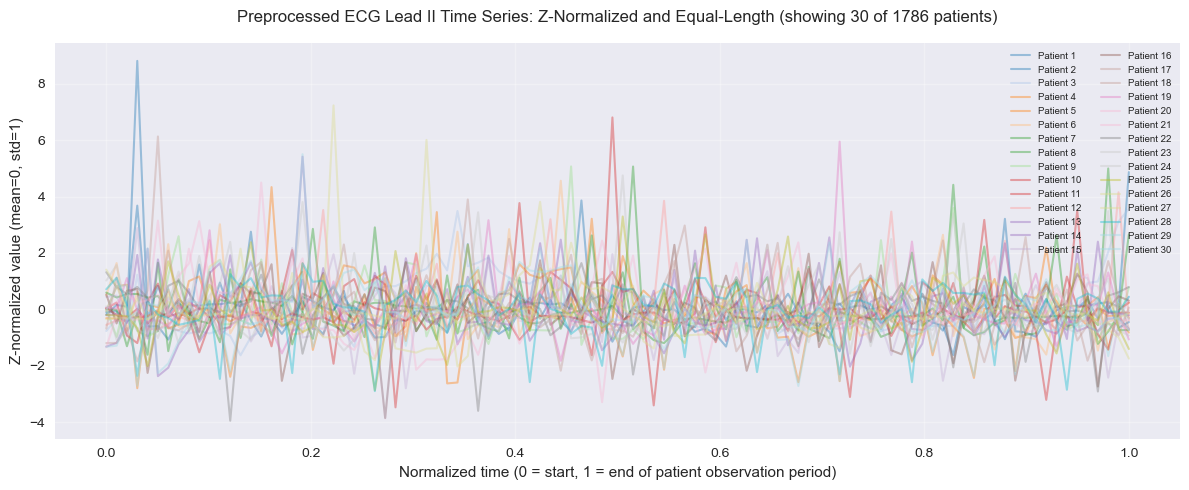

In [24]:
# Visualize a subset of normalized time series
plt.figure(figsize=(12, 5))
n_show = min(30, X_ts.shape[0])
colors = plt.cm.tab20(np.linspace(0, 1, n_show))
for i in range(n_show):
    plt.plot(np.linspace(0.0, 1.0, X_ts.shape[1]), X_ts[i], alpha=0.4, linewidth=1.5, 
             color=colors[i], label=f"Patient {i+1}")
plt.title(f"Preprocessed {target_label} Time Series: Z-Normalized and Equal-Length (showing {n_show} of {X_ts.shape[0]} patients)", fontsize=12, pad=15)
plt.xlabel("Normalized time (0 = start, 1 = end of patient observation period)", fontsize=11)
plt.ylabel("Z-normalized value (mean=0, std=1)", fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=7, ncol=2, framealpha=0.9)
plt.tight_layout()
plt.show()

In [25]:
# PAA feature extraction

def paa(series, n_segments):
    series = np.asarray(series)
    n = len(series)
    if n_segments > n:
        raise ValueError("n_segments must be <= length of series")

    idx = np.linspace(0, n, n_segments + 1, dtype=int)
    segments = []
    for i in range(n_segments):
        start = idx[i]
        end = idx[i + 1]
        seg_mean = series[start:end].mean()
        segments.append(seg_mean)
    return np.array(segments)

n_segments = 20  # PAA dimensionality (can adjust)
X_paa = np.vstack([paa(ts, n_segments) for ts in X_ts])

print(f"PAA feature matrix shape (patients x segments): {X_paa.shape}")

PAA feature matrix shape (patients x segments): (1786, 20)


## PAA Features

PAA reduces each time series to 20 segments (mean values). Reduces dimensionality from 100 to 20 while preserving shape.

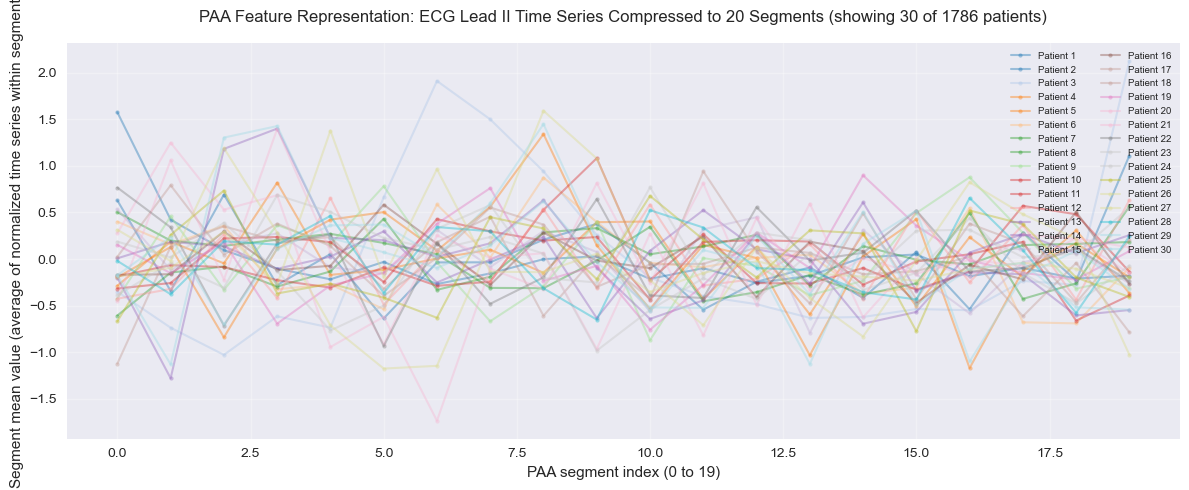

In [26]:
# Visualize PAA feature representation
plt.figure(figsize=(12, 5))
n_show = min(30, X_paa.shape[0])
colors = plt.cm.tab20(np.linspace(0, 1, n_show))
for i in range(n_show):
    plt.plot(range(n_segments), X_paa[i], alpha=0.4, linewidth=1.5, marker='o', markersize=3, 
             color=colors[i], label=f"Patient {i+1}")
plt.title(f"PAA Feature Representation: {target_label} Time Series Compressed to {n_segments} Segments (showing {n_show} of {X_paa.shape[0]} patients)", fontsize=12, pad=15)
plt.xlabel(f"PAA segment index (0 to {n_segments-1})", fontsize=11)
plt.ylabel("Segment mean value (average of normalized time series within segment)", fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=7, ncol=2, framealpha=0.9)
plt.tight_layout()
plt.show()

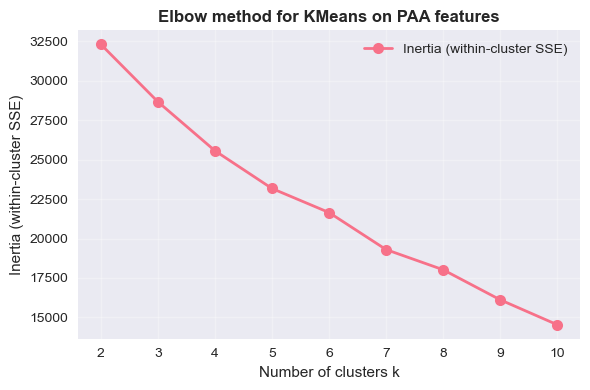

In [27]:
# KMeans clustering with elbow method

scaler = StandardScaler()
X_paa_scaled = scaler.fit_transform(X_paa)

ks = range(2, 11)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_paa_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(list(ks), inertias, marker="o", linewidth=2, markersize=8, label="Inertia (within-cluster SSE)")
plt.xlabel("Number of clusters k", fontsize=11)
plt.ylabel("Inertia (within-cluster SSE)", fontsize=11)
plt.title("Elbow method for KMeans on PAA features", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## Clustering

All clustering algorithms use only PAA features. Tabular data used later for cluster interpretation only.

0    832
1     68
2    376
3     66
4    444
Name: count, dtype: int64


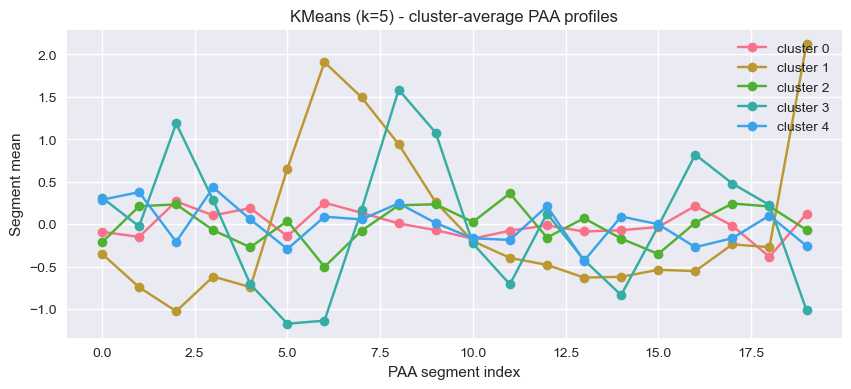

Silhouette score (KMeans, k=5): 0.211


In [28]:
# Choose k after inspecting the elbow plot
k_kmeans = 5  # adjust if elbow suggests a different value

kmeans = KMeans(n_clusters=k_kmeans, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_paa_scaled)

print(pd.Series(kmeans_labels).value_counts().sort_index())


def plot_cluster_profiles(X_paa, labels, title, alpha=1.0, legend_text=None):
    """
    Plot cluster average PAA profiles.
    
    Parameters:
    -----------
    X_paa : array-like
        PAA feature matrix
    labels : array-like
        Cluster labels
    title : str
        Plot title
    alpha : float, default=1.0
        Opacity of the plot lines (0.0 to 1.0)
    legend_text : str or None, default=None
        Custom legend text. If None, shows individual cluster labels.
    """
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    plt.figure(figsize=(10, 4))
    for lab in unique_labels:
        cluster_mean = X_paa[labels == lab].mean(axis=0)
        plt.plot(range(n_segments), cluster_mean, marker="o", label=f"cluster {lab}", alpha=alpha)
    
    plt.xlabel("PAA segment index")
    plt.ylabel("Segment mean")
    plt.title(title)
    
    if legend_text is not None:
        # Use custom legend text
        plt.legend([legend_text], loc='best', fontsize=9)
    else:
        # Use default individual cluster labels
        plt.legend()
    
    plt.grid(True)
    plt.show()

plot_cluster_profiles(X_paa, kmeans_labels, f"KMeans (k={k_kmeans}) - cluster-average PAA profiles")

sil_kmeans = silhouette_score(X_paa_scaled, kmeans_labels)
print(f"Silhouette score (KMeans, k={k_kmeans}): {sil_kmeans:.3f}")

## Cluster Profiling

Patient characteristics by cluster (age, gender, diagnosis).

In [29]:
# Load heart diagnoses data for cluster interpretation
df_heart = pd.read_csv(data_path / "heart_diagnoses_1.csv")
df_heart["charttime"] = pd.to_datetime(df_heart["charttime"], errors="coerce")

print(f"Heart Diagnoses loaded: {len(df_heart):,} rows")
print(f"Unique subjects: {df_heart['subject_id'].nunique():,}")

# Extract patient metadata and merge with cluster labels
# Get unique patient metadata from heart_diagnoses (age, gender, diagnosis)
patient_metadata = df_heart[
    ['subject_id', 'gender', 'age', 'icd_code', 'long_title']
].drop_duplicates(subset='subject_id').copy()

# Create a dataframe with patient_id and cluster label
cluster_df = pd.DataFrame({
    'subject_id': patient_ids,
    'cluster': kmeans_labels
})

# Merge cluster labels with patient metadata
cluster_profiles = cluster_df.merge(patient_metadata, on='subject_id', how='left')

print(f"Patients with cluster labels: {len(cluster_df)}")
print(f"Patients with metadata: {cluster_profiles['gender'].notna().sum()}")
print(f"\nCluster sizes:")
print(cluster_profiles['cluster'].value_counts().sort_index())
cluster_profiles.head(10)

Heart Diagnoses loaded: 4,864 rows
Unique subjects: 4,392
Patients with cluster labels: 1786
Patients with metadata: 1184

Cluster sizes:
cluster
0    832
1     68
2    376
3     66
4    444
Name: count, dtype: int64


,subject_id,cluster,gender,age,icd_code,long_title
0,10000980,0,F,75.0,I50,Heart failure
1,10004457,4,M,66.0,I35,Nonrheumatic aortic valve disorders
2,10007058,1,M,48.0,I21,Acute myocardial infarction
3,10018684,4,M,48.0,I48,Atrial fibrillation and flutter
4,10044096,4,M,53.0,I21,Acute myocardial infarction
5,10051074,0,F,71.0,I21,Acute myocardial infarction
6,10059952,0,M,73.0,I21,Acute myocardial infarction
7,10064049,2,M,70.0,I50,Heart failure
8,10075925,0,F,54.0,I50,Heart failure
9,10076616,0,M,64.0,I47,Paroxysmal tachycardia


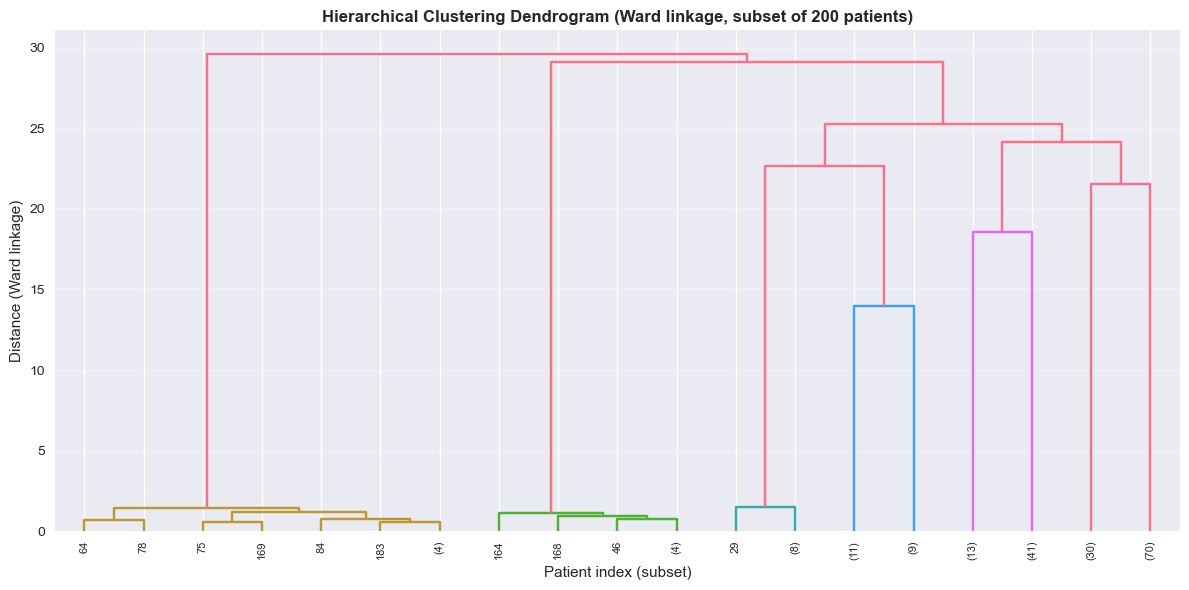

In [30]:
# Optional: Dendrogram visualization (on a subset for clarity)
from scipy.cluster.hierarchy import linkage, dendrogram

subset_size = min(200, X_paa_scaled.shape[0])
X_sub = X_paa_scaled[:subset_size]

Z = linkage(X_sub, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=4, leaf_rotation=90, leaf_font_size=8)
plt.title(f"Hierarchical Clustering Dendrogram (Ward linkage, subset of {subset_size} patients)", fontsize=12, fontweight='bold')
plt.xlabel("Patient index (subset)", fontsize=11)
plt.ylabel("Distance (Ward linkage)", fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

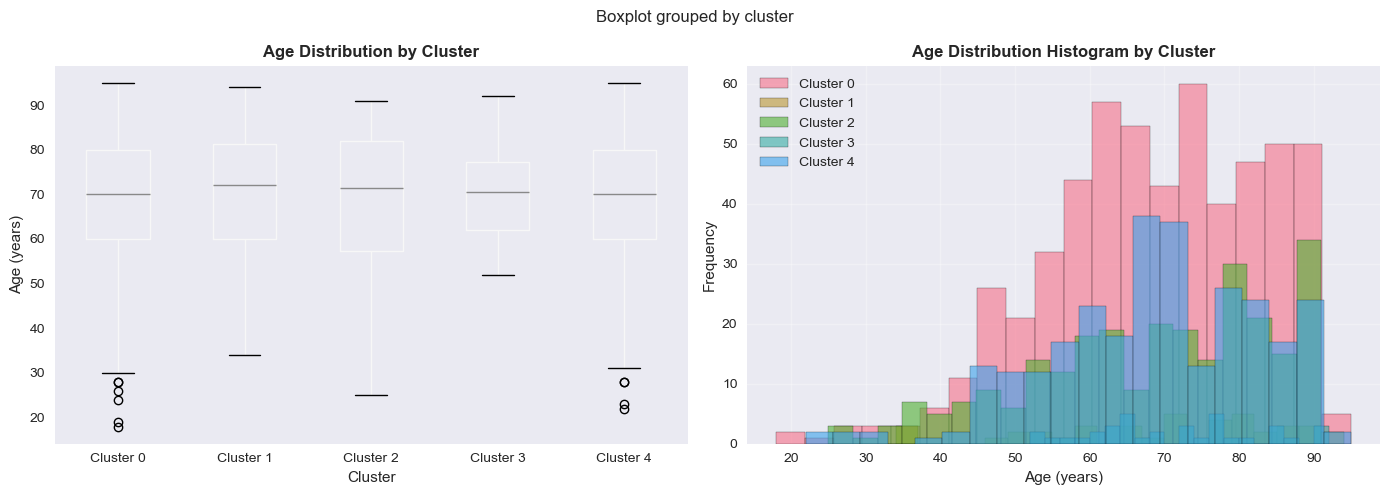

Age Statistics by Cluster:
         count       mean        std   min    25%   50%    75%   max
cluster                                                             
0        557.0  68.779174  14.530286  18.0  60.00  70.0  80.00  95.0
1         40.0  69.800000  16.213638  34.0  60.00  72.0  81.25  94.0
2        266.0  68.774436  16.308866  25.0  57.25  71.5  82.00  91.0
3         36.0  70.944444  11.191692  52.0  62.00  70.5  77.25  92.0
4        285.0  68.943860  14.119598  22.0  60.00  70.0  80.00  95.0


In [31]:
# Age distribution by cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot of age by cluster
cluster_profiles.boxplot(column='age', by='cluster', ax=axes[0], grid=False)
axes[0].set_title('Age Distribution by Cluster', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Age (years)', fontsize=11)
axes[0].set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)])

# Histogram of age distributions
for cluster_id in sorted(cluster_profiles['cluster'].unique()):
    cluster_ages = cluster_profiles[cluster_profiles['cluster'] == cluster_id]['age'].dropna()
    axes[1].hist(cluster_ages, alpha=0.6, label=f'Cluster {cluster_id}', bins=20, edgecolor='black')

axes[1].set_title('Age Distribution Histogram by Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Age (years)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("Age Statistics by Cluster:")
print(cluster_profiles.groupby('cluster')['age'].describe())

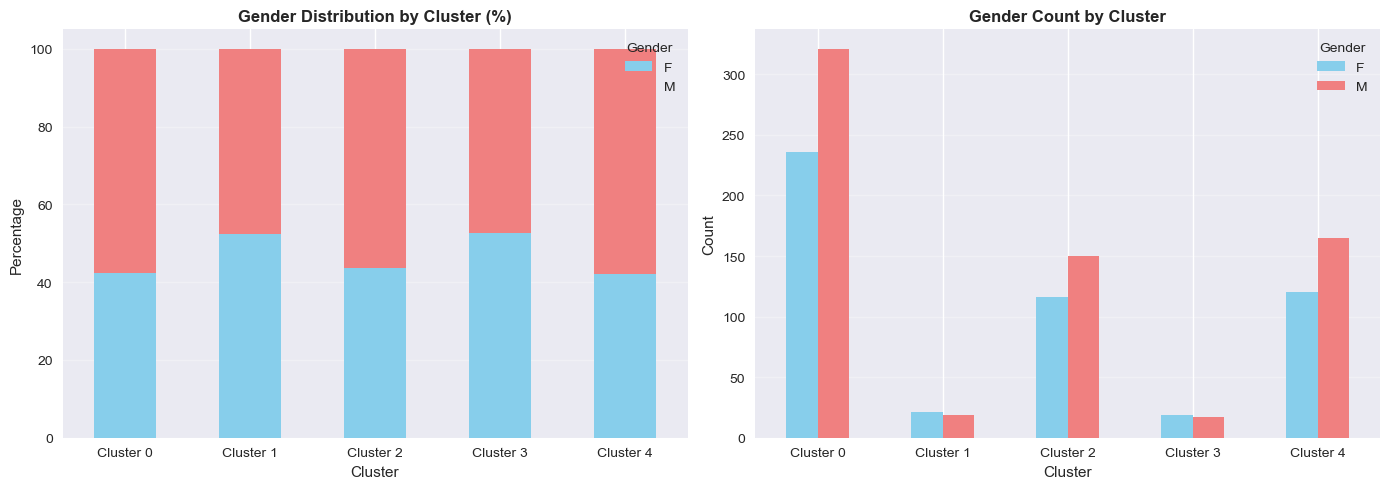

Gender Distribution by Cluster:
gender     F    M   All
cluster                
0        236  321   557
1         21   19    40
2        116  150   266
3         19   17    36
4        120  165   285
All      512  672  1184


In [32]:
# Gender distribution by cluster
gender_cluster = pd.crosstab(cluster_profiles['cluster'], cluster_profiles['gender'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
gender_cluster.plot(kind='bar', stacked=True, ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Gender Distribution by Cluster (%)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Percentage', fontsize=11)
axes[0].set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)], rotation=0)
axes[0].legend(title='Gender', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Count bar chart
gender_counts = pd.crosstab(cluster_profiles['cluster'], cluster_profiles['gender'])
gender_counts.plot(kind='bar', ax=axes[1], color=['skyblue', 'lightcoral'])
axes[1].set_title('Gender Count by Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)], rotation=0)
axes[1].legend(title='Gender', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Gender Distribution by Cluster:")
print(pd.crosstab(cluster_profiles['cluster'], cluster_profiles['gender'], margins=True))

Top 5 Diagnoses per Cluster:

Cluster 0 (n=832):
  1. Acute myocardial infarction: 183 (22.0%)
  2. Heart failure: 143 (17.2%)
  3. Atrial fibrillation and flutter: 66 (7.9%)
  4. Chronic ischemic heart disease: 55 (6.6%)
  5. Other diseases of pericardium: 21 (2.5%)

Cluster 1 (n=68):
  1. Acute myocardial infarction: 20 (29.4%)
  2. Heart failure: 6 (8.8%)
  3. Atrial fibrillation and flutter: 4 (5.9%)
  4. Chronic ischemic heart disease: 4 (5.9%)
  5. Other diseases of pericardium: 2 (2.9%)

Cluster 2 (n=376):
  1. Acute myocardial infarction: 107 (28.5%)
  2. Heart failure: 60 (16.0%)
  3. Chronic ischemic heart disease: 30 (8.0%)
  4. Atrial fibrillation and flutter: 25 (6.6%)
  5. Other diseases of pericardium: 10 (2.7%)

Cluster 3 (n=66):
  1. Acute myocardial infarction: 14 (21.2%)
  2. Heart failure: 7 (10.6%)
  3. Chronic ischemic heart disease: 5 (7.6%)
  4. Atrial fibrillation and flutter: 4 (6.1%)
  5. Other diseases of pericardium: 3 (4.5%)

Cluster 4 (n=444):
  1. Acute 

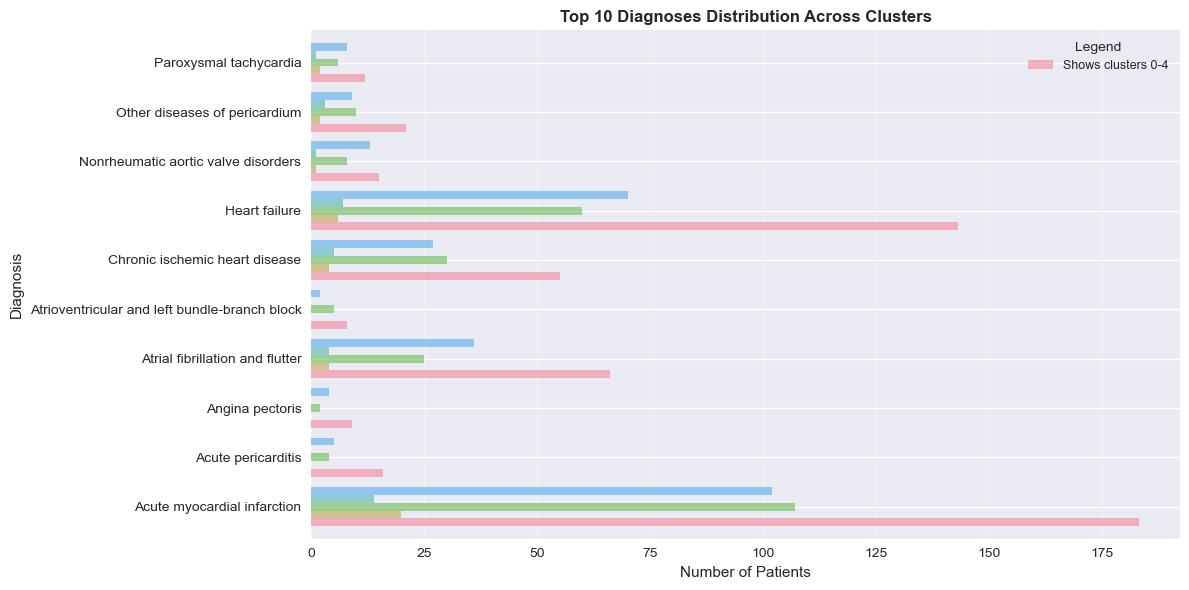

In [33]:
# Top diagnoses by cluster
print("Top 5 Diagnoses per Cluster:")
print("=" * 80)

for cluster_id in sorted(cluster_profiles['cluster'].unique()):
    cluster_diag = cluster_profiles[cluster_profiles['cluster'] == cluster_id]['long_title'].value_counts().head(5)
    print(f"\nCluster {cluster_id} (n={len(cluster_profiles[cluster_profiles['cluster'] == cluster_id])}):")
    for idx, (diag, count) in enumerate(cluster_diag.items(), 1):
        pct = (count / len(cluster_profiles[cluster_profiles['cluster'] == cluster_id])) * 100
        print(f"  {idx}. {diag}: {count} ({pct:.1f}%)")

# Visualize most common diagnoses across clusters
top_diag_overall = cluster_profiles['long_title'].value_counts().head(10).index.tolist()

fig, ax = plt.subplots(figsize=(12, 6))
diag_cluster = pd.crosstab(cluster_profiles['long_title'], cluster_profiles['cluster'])
diag_cluster_filtered = diag_cluster[diag_cluster.index.isin(top_diag_overall)]

diag_cluster_filtered.plot(kind='barh', ax=ax, width=0.8, alpha=0.5)
ax.set_title(f'Top 10 Diagnoses Distribution Across Clusters', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Patients', fontsize=11)
ax.set_ylabel('Diagnosis', fontsize=11)
ax.legend([f'Shows clusters 0-{k_kmeans-1}'], title='Legend', fontsize=9, loc='best')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

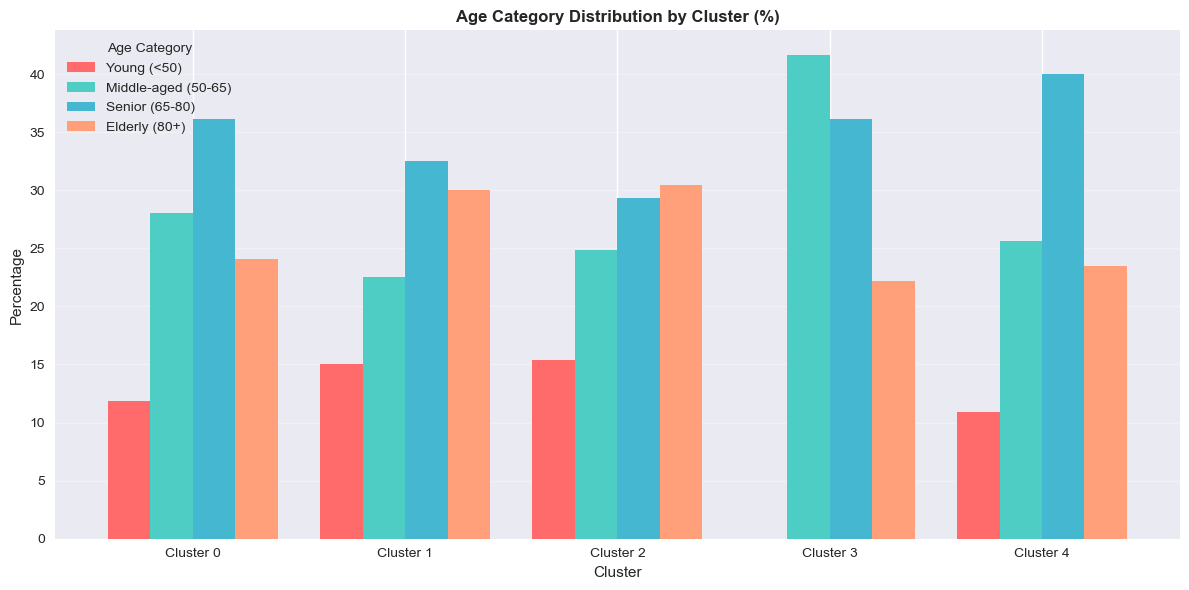

Age Category Distribution by Cluster:
age_category  Young (<50)  Middle-aged (50-65)  Senior (65-80)  Elderly (80+)  \
cluster                                                                         
0                      66                  156             201            134   
1                       6                    9              13             12   
2                      41                   66              78             81   
3                       0                   15              13              8   
4                      31                   73             114             67   
All                   144                  319             419            302   

age_category   All  
cluster             
0              557  
1               40  
2              266  
3               36  
4              285  
All           1184  


In [34]:
# Create age categories for easier interpretation
cluster_profiles['age_category'] = pd.cut(
    cluster_profiles['age'], 
    bins=[0, 50, 65, 80, 120], 
    labels=['Young (<50)', 'Middle-aged (50-65)', 'Senior (65-80)', 'Elderly (80+)']
)

# Age category distribution by cluster
age_cat_cluster = pd.crosstab(cluster_profiles['cluster'], cluster_profiles['age_category'], normalize='index') * 100

fig, ax = plt.subplots(figsize=(12, 6))
age_cat_cluster.plot(kind='bar', ax=ax, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], width=0.8)
ax.set_title('Age Category Distribution by Cluster (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Percentage', fontsize=11)
ax.set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)], rotation=0)
ax.legend(title='Age Category', fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("Age Category Distribution by Cluster:")
print(pd.crosstab(cluster_profiles['cluster'], cluster_profiles['age_category'], margins=True))

### Cluster Summary

Cluster characteristics based on age, gender, and diagnosis patterns.

0    467
1    592
2    126
3     68
4    533
Name: count, dtype: int64


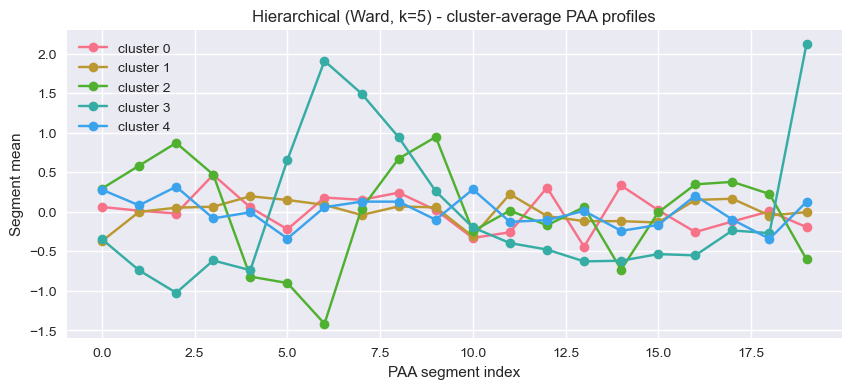

Silhouette score (Hierarchical, k=5): 0.193


In [35]:
# Hierarchical clustering (Ward linkage)

hier = AgglomerativeClustering(n_clusters=k_kmeans, linkage="ward")
hier_labels = hier.fit_predict(X_paa_scaled)

print(pd.Series(hier_labels).value_counts().sort_index())

plot_cluster_profiles(X_paa, hier_labels, f"Hierarchical (Ward, k={k_kmeans}) - cluster-average PAA profiles")

sil_hier = silhouette_score(X_paa_scaled, hier_labels)
print(f"Silhouette score (Hierarchical, k={k_kmeans}): {sil_hier:.3f}")

eps=0.5, min_samples=5 -> clusters=27, noise=1013
eps=0.5, min_samples=10 -> clusters=26, noise=1146
eps=0.5, min_samples=20 -> clusters=8, noise=1500
eps=0.8, min_samples=5 -> clusters=28, noise=148
eps=0.8, min_samples=10 -> clusters=27, noise=193
eps=0.8, min_samples=20 -> clusters=27, noise=257
eps=1.0, min_samples=5 -> clusters=28, noise=68
eps=1.0, min_samples=10 -> clusters=28, noise=75
eps=1.0, min_samples=20 -> clusters=27, noise=99
eps=1.2, min_samples=5 -> clusters=28, noise=26
eps=1.2, min_samples=10 -> clusters=28, noise=31
eps=1.2, min_samples=20 -> clusters=28, noise=40
DBSCAN labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26]
-1     193
 0      62
 1      68
 2      61
 3      46
 4      54
 5      65
 6      57
 7      46
 8      76
 9      68
 10     44
 11     56
 12     59
 13     72
 14     53
 15     62
 16     48
 17     70
 18     52
 19     57
 20     57
 21     70
 22     60
 23     52
 24     49
 25     66
 26     6

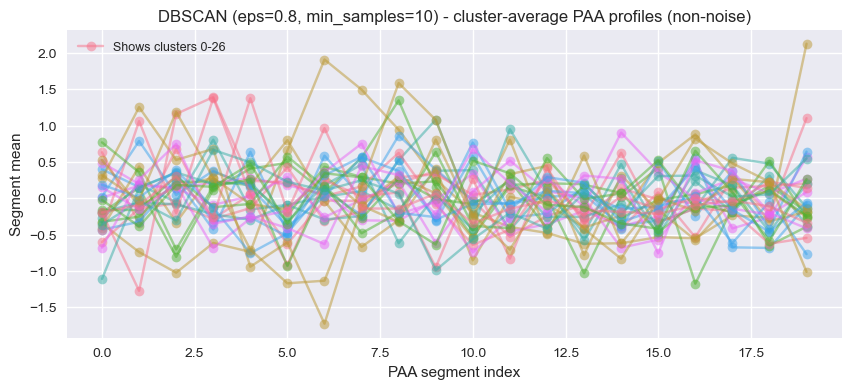

In [36]:
# DBSCAN clustering

# Try a couple of parameter combinations and inspect results
for eps in [0.5, 0.8, 1.0, 1.2]:
    for min_samples in [5, 10, 20]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_paa_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()
        print(f"eps={eps}, min_samples={min_samples} -> clusters={n_clusters}, noise={n_noise}")

# Choose a reasonable combination after inspecting the above output
eps_db = 0.8
min_samples_db = 10

dbscan = DBSCAN(eps=eps_db, min_samples=min_samples_db)
dbscan_labels = dbscan.fit_predict(X_paa_scaled)

unique_db_labels = np.unique(dbscan_labels)
print("DBSCAN labels:", unique_db_labels)
print(pd.Series(dbscan_labels).value_counts().sort_index())

mask_non_noise = dbscan_labels != -1
if mask_non_noise.sum() > 0:
    # Get unique cluster labels (excluding noise -1)
    unique_clusters = np.unique(dbscan_labels[mask_non_noise])
    n_clusters_found = len(unique_clusters)
    min_cluster = int(unique_clusters.min())
    max_cluster = int(unique_clusters.max())
    
    # Create legend text
    if n_clusters_found > 1:
        legend_text = f"Shows clusters {min_cluster}-{max_cluster}"
    else:
        legend_text = f"Shows cluster {min_cluster}"
    
    plot_cluster_profiles(
        X_paa[mask_non_noise],
        dbscan_labels[mask_non_noise],
        f"DBSCAN (eps={eps_db}, min_samples={min_samples_db}) - cluster-average PAA profiles (non-noise)",
        alpha=0.5,
        legend_text=legend_text
    )
else:
    print("All points considered noise for current DBSCAN parameters.")

### Summary

**Preprocessing:** ECG Lead II → z-normalization → PAA (20 segments)

**Methods:**
- KMeans: Elbow method for k selection
- Hierarchical: Ward linkage, dendrogram
- DBSCAN: Density-based, identifies noise

PAA features only.